This code can two part increment and decrement

# EE 596 Mini Project
Weerasingha W.K.H.M (E/18/383)

In [33]:
# Import the libraries
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os
import huffman

# Encode the image

Read the image

Image size of original image:  (480, 800)


True

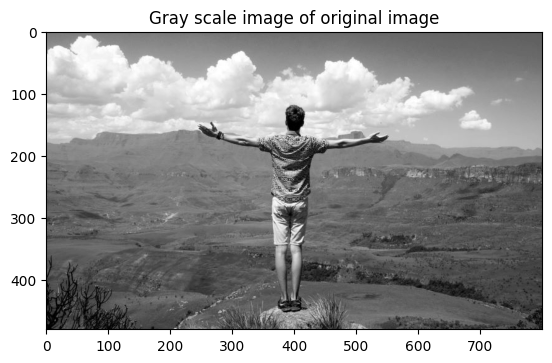

In [34]:
# Find the directory location
path = os.path.join(os.getcwd(), "Original_Image_Resize.jpg")

# Read the image as gray image
img  = cv2.imread(path, 0)

# Print the image size
print('Image size of original image: ', img.shape)

# Plot the image
plt.imshow(img, cmap = 'gray')
plt.title("Gray scale image of original image")

# Saved the gray scale image
cv2.imwrite("Original_gray.jpg", img)

 Resize the image

Image size of resize image :  (480, 800)


Text(0.5, 1.0, 'Gray scale image of resize image')

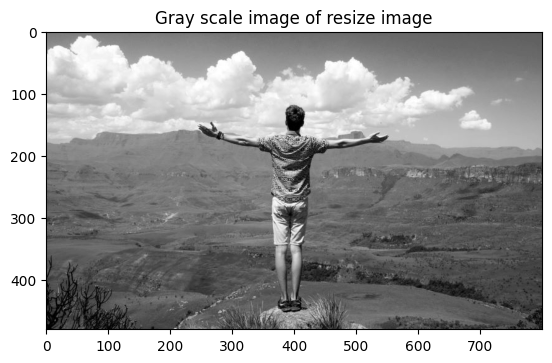

In [35]:
# Get the height and width of the original image
height, width = img.shape

# calculate the counts of the 8x8 macroblocks
block_size = 8
height_blocks = height // block_size
width_blocks = width // block_size

# Calculate new image dimensions
new_height = height_blocks * block_size
new_width = width_blocks * block_size

# Resize image to fit 8x8 macroblocks
resize_img = cv2.resize(img, (new_width, new_height))

# Print the size of resize image
print("Image size of resize image : ", resize_img.shape)

# Plot the resize image
plt.imshow(resize_img, cmap = 'gray')
plt.title("Gray scale image of resize image")


Get the macroblock

In [36]:
# Function to devide each frame in to marcoblocks
def macroblock(height_blocks, width_blocks, block_size, resize_img):
    # Get the macroblocks
    # create an empty 4D array to store the 8x8 marcoblocks
    macroblocks = np.zeros((height_blocks, width_blocks, block_size, block_size), dtype=np.uint8)

    # iterate over the height and width of the image and store the 8x8 blocks in the array
    for i in range(height_blocks):
        for j in range(width_blocks):
            macroblocks[i, j] = resize_img[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
    return macroblocks

Apply DCT to each macroblock 

In [37]:
# Apply dicrete cosine transform for each macroblocks

# Function to apply dicrete cosine transform
def dct_macroblocks(macroblocks):
    # Create an empty array to store the DCT of each macroblock
    dct_macroblocks = np.zeros(macroblocks.shape, dtype=np.float32)

    # Apply DCT to each macroblock
    for i in range(macroblocks.shape[0]):
        for j in range(macroblocks.shape[1]):
            dct_macroblocks[i, j] = cv2.dct(macroblocks[i, j].astype(np.float32))

    return dct_macroblocks


Quantization 

In [38]:
# Define Quntization matrix

ref_matrix = np.array([[16,  11,  10,  16,  24,  40,  51,  61],
                                [12,  12,  14,  19,  26,  58,  60,  55],
                                [14,  13,  16,  24,  40,  57,  69,  56],
                                [14,  17,  22,  29,  51,  87,  80,  62],
                                [18,  22,  37,  56,  68, 109, 103,  77],
                                [24,  35,  55,  64,  81, 104, 113,  92],
                                [49,  64, 78,  87, 103, 121, 120, 101],
                                [72,  92,  95,  98, 112, 100, 103 , 99]])  

# Low Quality 
# quantization_matrix_low = np.round(ref_matrix*8).astype(int)
quantization_matrix_low = (ref_matrix*8)

# Medium Quality 
quantization_matrix_medium = ref_matrix 

# High Quality
# quantization_matrix_high = np.round(ref_matrix/8).astype(int)
quantization_matrix_high = (ref_matrix/6)

# Ascked the quality level which want 
quality = int(input("Select the quality level (low:0, Medium:1, High:2) : "))

# Assign the values for variables according to the input level
if quality == 0:
    quantization_matrix = quantization_matrix_low 
    output_file_path = "encoded_low_quality.txt"
    image_output =  "Quantized_low_quality.jpg"
    huffman_path = "Huffman_low_quality.txt"

elif quality == 1:
    quantization_matrix = quantization_matrix_medium
    output_file_path = "encoded_medium_quality.txt"
    image_output =  "Quantized_medium_quality.jpg"
    huffman_path = "Huffman_medium_quality.txt"

else:
    quantization_matrix = quantization_matrix_high
    output_file_path = "encoded_high_quality.txt"
    image_output =  "Quantized_high_quality.jpg"
    huffman_path = "Huffman_high_quality.txt"

Function for quantization

In [39]:
# Function for quantize 

# def qunatizer(block_0, block_1, matix, frame):
def qunatizer(matix, frame):
    # Create architectural metrix to store the results
    archi_matrix = np.zeros((frame.shape[0], frame.shape[1], frame.shape[2], frame.shape[3]),  dtype = np.float32)
    # Quantize each marcoblocks
    for i in range(frame.shape[0]):
        for j in range(frame.shape[1]):
            # Quantize the image by rounding the pixel values to the nearest quantization level
            archi_matrix[i, j] = np.round(frame[i, j] / matix)
    
    return archi_matrix

Function to Re annange to 2D

In [40]:
# Function to recreate the 2D image matrix
def recreate(quantized_image):
    for i in  range((quantized_image.shape[0])):
            a = quantized_image[i, 0] 
            for j in range((quantized_image.shape[1])-1):
                    b = quantized_image[i, j+1] 
                    c = np.concatenate((a,b), axis=1) # Concatanate marcoblocks along rows
                    a = c
            if i == 0:
                    f = c
            if i>0:
                    Matrix_2D = np.concatenate((f,c), axis=0) # Concatanate marcoblocks along columns
                    f = Matrix_2D
    return Matrix_2D

Function to find the probability distribution

In [41]:
# Function to find prbability distribution
def probability(Matrix_2D):
    symbols = {}
    for pixel in Matrix_2D.flatten():
        if pixel in symbols:
            # symbols[str(pixel)] += 1
            symbols[(pixel)] += 1
        else:
            # symbols[str(pixel)] = 1
            symbols[(pixel)] = 1

    # Calculate probability distribution
    total_pixels = Matrix_2D.shape[0]*Matrix_2D.shape[1]
    probability_distribution = {}
    for item in symbols:
        probability_distribution[item] = symbols[item]/total_pixels

    # Get the above result as a list
    return  [(str(symbol), weight) for symbol, weight in probability_distribution.items()]

Encoder Function

In [42]:
# Function for compressing the image
def encoder(image, huffman):
    img_copy = image
    symbol =  huffman ## Halfman values
    codeWord = str()
    # Quantize the image
    for i in range(img_copy.shape[0]):
        for j in range(img_copy.shape[1]):
            # print(str(img_copy[i, j]))
            codeWord += symbol[(img_copy[i, j])]

    return  codeWord

Function to call above function

In [43]:
def operator( quantization_matrix, dct_macroblocks):
    # Quantized the image
    quantized_image = qunatizer(quantization_matrix, dct_macroblocks)
    Matrix_2D = recreate(quantized_image)
    sym_weight_lst = probability(Matrix_2D)
    
    # Create a dictionary for the huffman codebook
    huff_map = huffman.codebook(sym_weight_lst)
    huff_map = dict([(float(symbol), weight) for symbol, weight in huff_map.items()])

    encoded_original = (encoder(Matrix_2D, huff_map))

    return encoded_original, huff_map, Matrix_2D

Function to find PSNR value

In [44]:
# Function to find PSNR
def PSNR(image1, image2):
    mse = np.mean((np.subtract(image1, image2)**2))
    max_pixel = 255
    psnr = 20 * np.log10(max_pixel) - 10 * np.log10(mse)
    return psnr

In [45]:
# Separate the image into marcoblocks
macroblocks = macroblock(height_blocks, width_blocks, block_size, resize_img)

In [46]:
# Apply DCT to each macroblock
dct_macroblocks = dct_macroblocks(macroblocks)

In [47]:
# Call the operator function
encoded_original, huff_map, Matrix_2D = operator( quantization_matrix, dct_macroblocks)
print(len(encoded_original))

817816


In [48]:
#Save the encoded data to a text file
file =  open(output_file_path, 'w')

# Encode the each marcoblock separately and save result in the text file
file.write(str(encoded_original))

file.close()


# Decode the encoded image

In [49]:

# Read the saved file line by line
file1 = open(output_file_path, 'r')
Lines = file1.read()

# Encode the text file and create the 4D matrix 
decoded_matrix = Lines
            
file1.close()

HUffman decoder

In [50]:
# Function to the decode the compressed haufman coded file
def decoder(data, size, txtfile):
    codeVal = []
    data_new = dict([(value, key) for key, value in data.items()])

    code_list = list(data.values())

    i = 0
    # decode the read file's data
    while i != len(txtfile):
        # Check with the huffman codes
        for j in range(len(code_list)):
            a0 = txtfile[i:(i+len(code_list[j]))]
            if (a0 == code_list[j]):
                codeVal.append(data_new[code_list[j]])
                i+=len(code_list[j])
                break

    merge_image = np.array(codeVal).reshape(size)
    merge_image = merge_image.astype(float)

    return merge_image

In [51]:
# Decode 
decoded_original_1 = decoder(huff_map, Matrix_2D.shape, decoded_matrix)

Reconstruct the marcoblocks

In [52]:
# create an empty 4D array to store the 8x8 marcoblocks
macroblocks_2 = np.zeros((height_blocks, width_blocks, block_size, block_size)).astype(float)

# iterate over the height and width of the image and store the 8x8 blocks in the array
for i in range(height_blocks):
    for j in range(width_blocks):
        macroblocks_2[i, j] = decoded_original_1[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]

Dequantize the decoded result

In [53]:
# Function for Dequantize 

def dequantized(height_blocks, width_blocks, block_size, frame):
    # Create a 4D matrix to store dequantized result
    decoded_quantized = np.zeros((height_blocks, width_blocks, block_size, block_size))

    # Dequantize occur marcoblock by marcoblock
    for i in range(frame.shape[0]):
            for j in range(frame.shape[1]):
                decoded_quantized[i, j] = (frame[i,j] * quantization_matrix)
    return decoded_quantized

In [54]:
# Dequantized
decoded_quantized = dequantized(height_blocks, width_blocks, block_size, macroblocks_2)

Inverse DCT

In [55]:
# Function for IDCT
def IDCT(frame_macro):
    # Create an empty array to store the IDCT of each macroblock
    inverse_dct = np.zeros(frame_macro.shape)

    # Apply DCT to each macroblock
    for i in range(frame_macro.shape[0]):
        for j in range(frame_macro.shape[1]):
            inverse_dct[i, j] = (cv2.idct(np.float32(frame_macro[i, j])))
    
    return inverse_dct

In [56]:
# Get the inverse DCT
inverse_dct = IDCT(decoded_quantized)

In [57]:
# Recreate the 2D matrix
result = recreate(inverse_dct)

In [58]:
# Clip the pixel values to the valid range (0-255)
reconstructed_image = np.clip(result, 0, 255).astype(np.uint8)

True

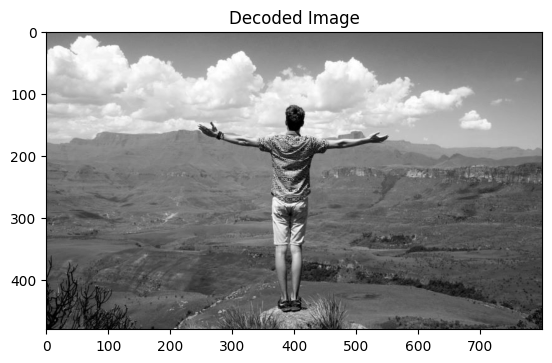

In [59]:
# Plot the decoded image
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Decoded Image")

# Save the image
cv2.imwrite(image_output, reconstructed_image)

Find the PSNR

In [60]:
# Function to find PSNR
def PSNR(image1, image2):
    mse = np.mean((np.subtract(image1, image2)**2))
    max_pixel = 255
    psnr = 20 * np.log10(max_pixel) - 10 * np.log10(mse)
    return psnr

In [61]:
# Find the PSNR using decoded image and resized grayscaled image
psnr_score0 = PSNR(resize_img, np.clip(result, 0, 255).astype(np.uint8))

In [62]:
# Print the PSNR value
print("PSNR avlue : ", psnr_score0)

PSNR avlue :  47.55010383610829


In [63]:
# Get the Compression ratio
compression_ration = (resize_img.shape[0]*resize_img.shape[1]*8)/len(decoded_matrix)

In [64]:
# Print the CR
print("Compression ration : ", compression_ration)

Compression ration :  3.7563461707768004
